In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

base_dir = '/kaggle/input/cremad/AudioWAV'

emotion_map = {
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'SAD': 'sad',
    'NEU': 'neutral'
}

def load_data_from_directory(base_dir, emotion_map):
    data = []
    for filename in os.listdir(base_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(base_dir, filename)
            parts = filename.split('_')
            if len(parts) >= 3:  
                emotion_code = parts[2]
                if emotion_code in emotion_map:
                    emotion = emotion_map[emotion_code]
                    data.append({'file_path': file_path, 'emotion': emotion})
    return pd.DataFrame(data)

cremad_data = load_data_from_directory(base_dir, emotion_map)

label_encoder = LabelEncoder()
cremad_data['label'] = label_encoder.fit_transform(cremad_data['emotion'])

train_data, test_data = train_test_split(cremad_data, test_size=0.1, random_state=42)
print(cremad_data.head())


                                           file_path  emotion  label
0  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav  disgust      1
1  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav    happy      3
2  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav    happy      3
3  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav  disgust      1
4  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav  disgust      1


In [3]:
unique_emo = cremad_data['label'].unique()
print(unique_emo)

[1 3 5 4 2 0]


In [4]:
class SERDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 2]
        audio, _ = librosa.load(file_path, sr=16000)
        processed_audio = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return processed_audio.input_values.squeeze(), torch.tensor(label)

In [5]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    max_length = max([inp.shape[0] for inp in inputs])
    padded_inputs = [torch.nn.functional.pad(inp, (0, max_length - inp.shape[0])) for inp in inputs]
    processed_inputs = torch.stack(padded_inputs)
    return processed_inputs, torch.tensor(labels)

In [6]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
train_dataset = SERDataset(train_data, processor)
test_dataset = SERDataset(test_data, processor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_encoder.classes_))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

train_accuracies = [] 
train_losses = []
val_losses = []
val_accuracies = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
num_epochs = 100
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

    scheduler.step(avg_val_loss)

print("Training complete!")


Validation: 100%|██████████| 94/94 [00:14<00:00,  6.43it/s]


Epoch 1/100, Train Loss: 1.6409, Train Accuracy: 0.3164, Val Loss: 1.4690, Val Accuracy: 0.3758


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.55it/s]


Epoch 2/100, Train Loss: 1.4657, Train Accuracy: 0.4023, Val Loss: 1.4589, Val Accuracy: 0.4013


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.53it/s]


Epoch 3/100, Train Loss: 1.3998, Train Accuracy: 0.4324, Val Loss: 1.3501, Val Accuracy: 0.4443


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.69it/s]


Epoch 4/100, Train Loss: 1.2933, Train Accuracy: 0.4935, Val Loss: 1.3233, Val Accuracy: 0.5060


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.61it/s]


Epoch 5/100, Train Loss: 1.1125, Train Accuracy: 0.5835, Val Loss: 1.1132, Val Accuracy: 0.5946


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.78it/s]


Epoch 6/100, Train Loss: 0.9757, Train Accuracy: 0.6478, Val Loss: 1.0258, Val Accuracy: 0.6403


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.63it/s]


Epoch 7/100, Train Loss: 0.8524, Train Accuracy: 0.6957, Val Loss: 1.0336, Val Accuracy: 0.6443


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.53it/s]


Epoch 8/100, Train Loss: 0.7670, Train Accuracy: 0.7284, Val Loss: 0.9592, Val Accuracy: 0.6993


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.72it/s]


Epoch 9/100, Train Loss: 0.7046, Train Accuracy: 0.7514, Val Loss: 1.0999, Val Accuracy: 0.6617


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.55it/s]


Epoch 10/100, Train Loss: 0.6396, Train Accuracy: 0.7757, Val Loss: 0.8545, Val Accuracy: 0.7235


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.89it/s]


Epoch 11/100, Train Loss: 0.6067, Train Accuracy: 0.7866, Val Loss: 0.9394, Val Accuracy: 0.7060


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.70it/s]


Epoch 12/100, Train Loss: 0.5549, Train Accuracy: 0.8090, Val Loss: 0.8934, Val Accuracy: 0.7208


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.66it/s]


Epoch 13/100, Train Loss: 0.5126, Train Accuracy: 0.8247, Val Loss: 0.7826, Val Accuracy: 0.7557


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.42it/s]


Epoch 14/100, Train Loss: 0.4700, Train Accuracy: 0.8350, Val Loss: 0.8081, Val Accuracy: 0.7503


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.66it/s]


Epoch 15/100, Train Loss: 0.4333, Train Accuracy: 0.8507, Val Loss: 0.8696, Val Accuracy: 0.7463


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.75it/s]


Epoch 16/100, Train Loss: 0.4107, Train Accuracy: 0.8608, Val Loss: 0.9086, Val Accuracy: 0.7275


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.78it/s]


Epoch 17/100, Train Loss: 0.3325, Train Accuracy: 0.8894, Val Loss: 0.8286, Val Accuracy: 0.7450


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.45it/s]

Epoch 18/100, Train Loss: 0.2841, Train Accuracy: 0.9047, Val Loss: 0.8787, Val Accuracy: 0.7369
Early stopping triggered
Training complete!


In [10]:
torch.save(model.state_dict(), 'wav2vec_cremad_18.pth')

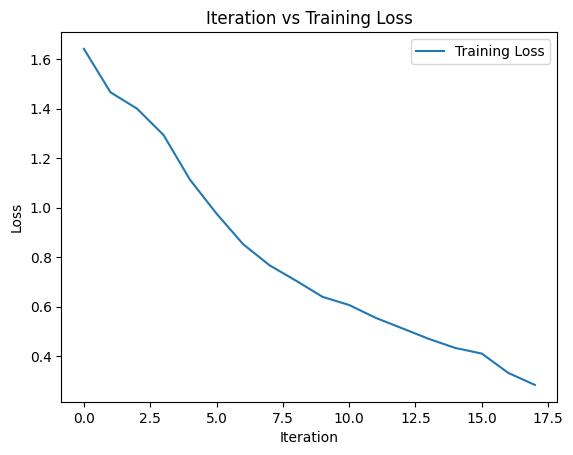

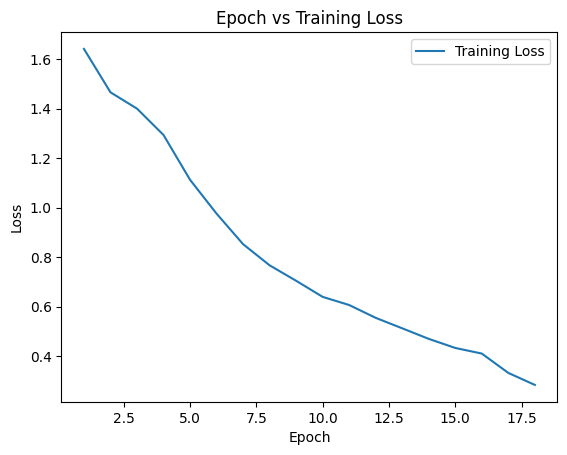

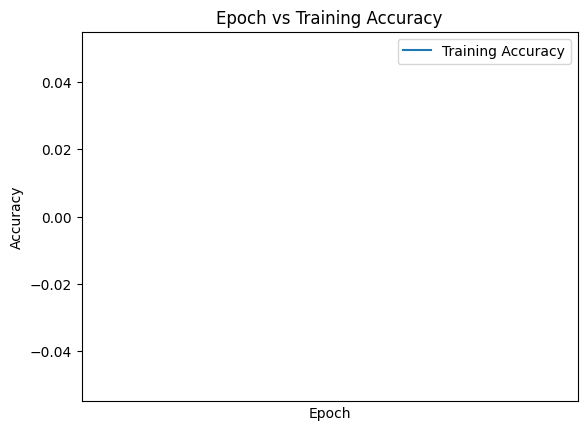

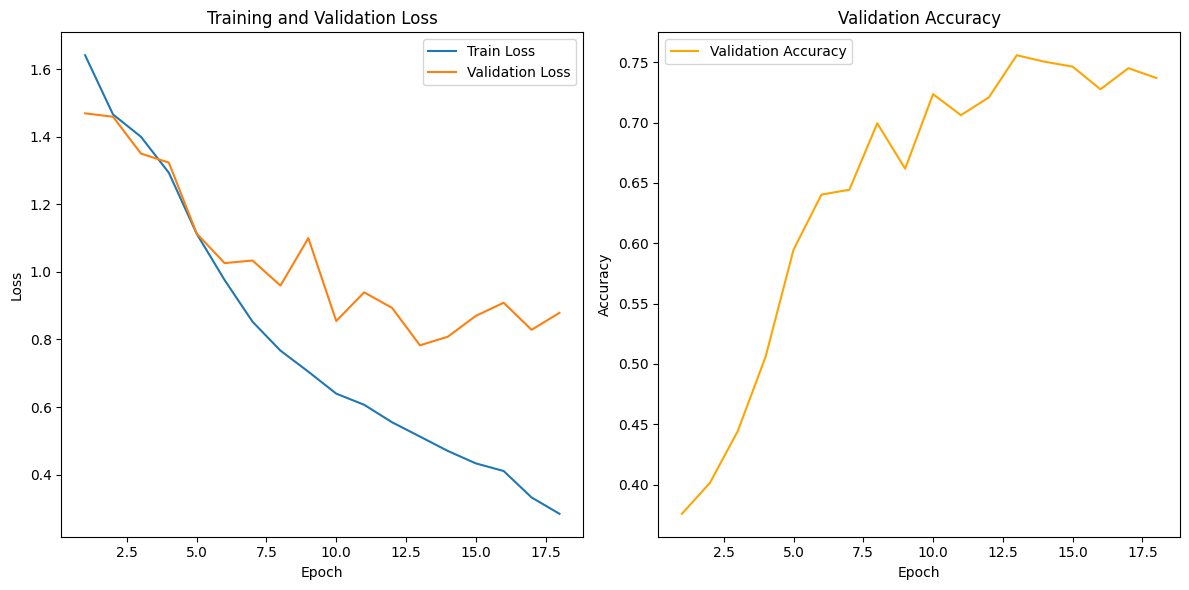

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Loss
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(1, len(train_accuracies) + 1)  # Epochs from 1 to the number of epochs
plt.plot(acc_X, train_accuracies, "-", label="Training Accuracy")
plt.xticks(acc_X)  # Ensures x-axis shows every epoch number
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()


In [15]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm
import time

# Assuming test_loader is already defined as a DataLoader for your test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels": [], "predictions": []}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        # Assuming the input values are in the format of input_values and attention_mask
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        
        # Get predictions (assuming classification with argmax)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate correct predictions and total count
        correct += (preds == labels).sum().item()
        count += labels.size(0)
        
        # Calculate accuracy
        accuracy = correct / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Store the labels and predictions for classification report
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += preds.cpu().numpy().tolist()
        
    pbar.close()

    time.sleep(0.3)
    print(f"The final accuracy on the test dataset: {accuracy * 100:.4f}%")

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(record["labels"], record["predictions"], digits=4))


100%|██████████| 745/745 [00:13<00:00, 55.66it/s, loss=0.078, accuracy=0.737]


The final accuracy on the test dataset: 73.6913%

Classification Report:
              precision    recall  f1-score   support

           0     0.7303    0.9353    0.8202       139
           1     0.6934    0.7422    0.7170       128
           2     0.7312    0.5620    0.6355       121
           3     0.7963    0.6880    0.7382       125
           4     0.7769    0.8319    0.8034       113
           5     0.7037    0.6387    0.6696       119

    accuracy                         0.7369       745
   macro avg     0.7386    0.7330    0.7307       745
weighted avg     0.7380    0.7369    0.7321       745



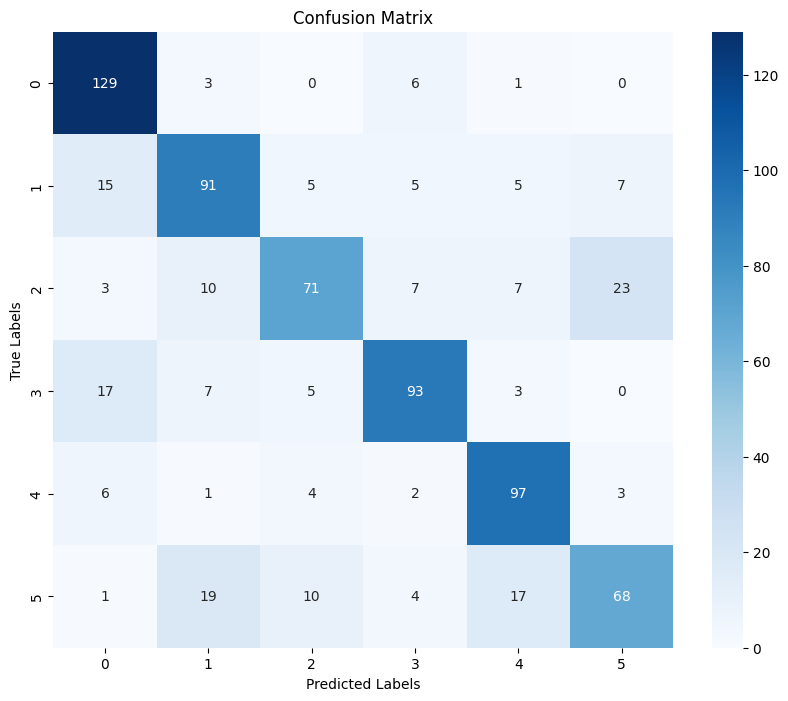

In [16]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

checkpoint_path = '/kaggle/working/model_50_crema.pth'

# Check if the checkpoint exists
if os.path.exists(checkpoint_path):
    # Load checkpoint (model weights and optimizer state)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_accuracies = checkpoint['train_accuracies']
    print(f"Resumed training from epoch {epoch_start + 1}")
else:
    # Start fresh if no checkpoint is found
    epoch_start = 0
    train_loss = []
    train_accuracies = []
    print("No checkpoint found, starting training from scratch.")

model.train()

# Set the number of epochs you want to continue training for
num_epochs = 5

for epoch_i in range(epoch_start, epoch_start + num_epochs):
    print(f'Epoch {epoch_i + 1}/{epoch_start + num_epochs}')
    time.sleep(0.3)
    
    # Create DataLoader for each epoch
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    correct = 0
    count = 0
    epoch_loss = []
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        
        # Move inputs and labels to the device (GPU or CPU)
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # Backward pass
        loss.backward()
        optim.step()
        
        # Prediction and accuracy calculation
        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count
        pbar.set_postfix({'Loss': f'{loss.item():.3f}', 'Accuracy': f'{accuracy:.3f}'})
        
        # Save the loss for the epoch
        epoch_loss.append(loss.item())
    
    pbar.close()
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch_i + 1,  # Save the current epoch number
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'train_loss': train_loss,
        'train_accuracies': train_accuracies,
    }, checkpoint_path)
    print(f"Checkpoint saved for epoch {epoch_i + 1}")

print("Training complete!")


No checkpoint found, starting training from scratch.
Epoch 1/5


  0%|          | 0/3349 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [27761] at entry 0 and [40574] at entry 1